# target 기준 

In [2]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score ,mean_squared_error

seeds = [42,16,10]
model_name = 'xlm-roberta-base'
task = 'tydiqa'

feature_name = 'fisher'

if task == 'ner':
    dataset = 'wikiann'
elif task == 'pos':
    dataset = 'ud'
elif task == 'tydiqa':
    dataset = 'tydiqa'
elif task =='cls':
    dataset = 'paws-x'
elif task =='nli':
    dataset = 'xnli'

fseeds=[42,16,10]
fshot=1024
if feature_name == 'fisher':
    shot =1024
else:
    shot = None
percent = 0.15
is_plt =False
free_file = None
if True:
    aver = 0
    saver = 0
    acc = 0
    adv = 0
    top5acc = 0
    top3acc = 0
    sueadv = 0
    ar,ap,asr,asp =0,0,0,0
    eng =0
    act =0
    afeature = []
    
    ndcg = 0
    rmse = 0
for fseed in fseeds:
    for seed in seeds:
        scfile = f'./output/output_csv/{seed}/{task}_zeroshot({model_name}).csv'
        score_df = pd.read_csv(scfile)
        score_df.index=list(score_df['Unnamed: 0'])
        score_df.drop(columns=['Unnamed: 0'],inplace=True)
        if free_file != None:
            feature_file = free_file
        elif feature_name == 'regression':
            if task =='tydiqa':
                feature_file = f'./output/output_csv/regression_qa_ols_{seed}.csv'
            else:
                feature_file = f'./output/regression_{task}_ols_{seed}.csv'
        elif feature_name =='emb':
            feature_file = f'./output/output/output_csv/low_resource/low_resource_ner-1024-{seed}/layer12_embed_sim_result.csv'
            feature_file = f'./output/output_csv/{task}-{seed}/layer5_embed_sim_result.csv'
        elif shot == None:
            feature_file = f'./output/output_csv/{model_name}/{task}_{dataset}_{feature_name}_{fshot}_{fseed}.csv'
        elif percent ==None:
            feature_file = f'./output/output_csv/{model_name}/{task}_{feature_name}_1024_42_overlap.csv'
        else:
            feature_file = f'./output/output_csv/{model_name}/{feature_name}/{task}_{feature_name}_{dataset}_{shot}_{percent}_{fseed}_overlap.csv'
        feature_df = pd.read_csv(feature_file)
        #print(feature_file)
        feature_df.index = list(feature_df['Unnamed: 0'])
        feature_df.drop(columns=['Unnamed: 0'],inplace=True)
        
        if task =='tydiqa':        
            dellist = ['korean']
            if len(dellist) != 0 :
                feature_df.drop(columns=dellist,inplace=True)
                feature_df.drop(index=dellist,inplace=True)
                score_df.drop(columns=dellist,inplace=True)
                score_df.drop(index=dellist,inplace=True)

        plt.figure(figsize=(8,6))
        for target in score_df.columns:
            score = list(score_df[target])
            if target in list(score_df.index):
                cur = score.pop(list(score_df.index).index(target))

            feature = list(feature_df[target])
            feature.pop(list(score_df.index).index(target))
            # print(score,feature)
            r,p = stats.pearsonr(score,feature)
            sr,sp = stats.spearmanr(score,feature)

            #print(f'{target} -> pearson :{round(r,4)}  p-value :{round(p,4)}')
            aver += r
            saver += sr

            if is_plt :
                a, b = np.polyfit(feature, score, 1)
                plt.scatter(feature, score)
                plt.plot(feature, a*np.array(feature)+b,label=target)

            if feature_name in ['ldnd','ttr_distance','wf','lex']:
                if feature.index(min(feature)) == score.index(max(score)) :
                    acc +=1
                if target != 'en':
                    adv += score[feature.index(min(feature))]-score[0]
                    eng += score[0] 
                    act += score[feature.index(min(feature))]
                sueadv += score[feature.index(min(feature))]-score[len(score)-1]
                sorted_mask = sorted(feature)
                true_rel = list(pd.DataFrame(score).rank()[0])
                rel = list(pd.DataFrame(feature).rank(ascending=False)[0])
                ndcg+=ndcg_score([true_rel],[rel],k=3)
            else:    
                if feature.index(max(feature)) == score.index(max(score)):
                    acc +=1
                if target != 'en': 
                    adv += score[feature.index(max(feature))]-score[0]
                    eng += score[0] 
                    act += score[feature.index(max(feature))]
                sorted_mask = sorted(feature,reverse=True)

                true_rel = list(pd.DataFrame(score).rank()[0])
                rel = list(pd.DataFrame(feature).rank()[0])
                #print(ndcg_score([true_rel],[rel],k=3))
                ndcg+=ndcg_score([true_rel],[rel],k=3)

            for i in range(5):
                if score[feature.index(sorted_mask[i])] == max(score):
                    if i<3:
                        top3acc += 1
                        top5acc += 1
                    else:
                        top5acc += 1
                    break
#print(top3acc)
#print((len(seeds)*len(fseeds)))
ndcg /= (len(seeds)*len(fseeds))
aver /= (len(seeds)*len(fseeds))
saver /= (len(seeds)*len(fseeds))
eng /= (len(seeds)*len(fseeds))
act /= (len(seeds)*len(fseeds))
acc /= (len(seeds)*len(fseeds))
top3acc /= (len(seeds)*len(fseeds))
top5acc /= (len(seeds)*len(fseeds))
adv /= (len(seeds)*len(fseeds))
# sueadv /= (len(seeds)*len(fseeds))


print(f"ndcg average : {round(ndcg/(len(score_df.index)),4)}")
print(f"pearson average : {round(aver/(len(score_df.index)),4)}")
print(f"spearman average : {round(saver/(len(score_df.index)),4)}")
print(f'adv average : { round(adv/(len(score_df.index)),4)   }')
print(f'top1 acc : {round(acc/(len(score_df.index)),4)}')
print(f'top3 acc : {round(top3acc/(len(score_df.index)),4)}')
print(f'top5 acc : {round(top5acc/(len(score_df.index)),4)}')

print(f'eng : {round(eng/(len(score_df.index)-1),4)}')
print(f'ours : {round(act/(len(score_df.index)-1),4)}')
# print(f'advantage over english : {round(adv/(len(score_df.columns)-1),4)}')
# print(f'advantage over SuE : {round(sueadv/(len(score_df.columns)),4)}')
if is_plt:
    plt.xlabel(f'{feature_name}')
    plt.ylabel('transfer score')
    plt.legend(loc='center left', ncol=1, bbox_to_anchor=(1, 0.5))
    plt.show()


ndcg average : 0.8795
pearson average : 0.7258
spearman average : 0.6815
adv average : 5.0228
top1 acc : 0.5
top3 acc : 0.9167
top5 acc : 1.0
eng : 61.1439
ours : 66.8842


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

# all

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


rmse: 9.5803
R-square: 0.6599


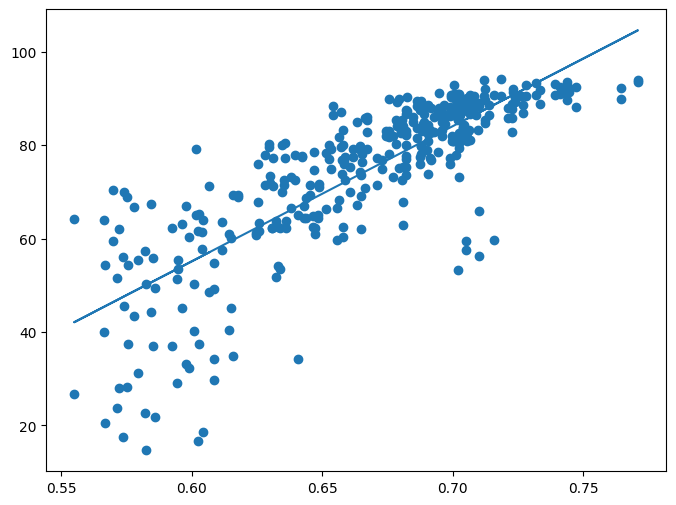

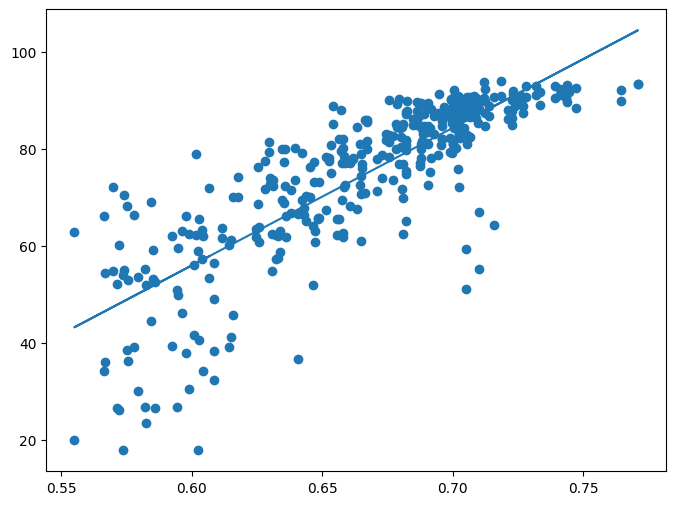

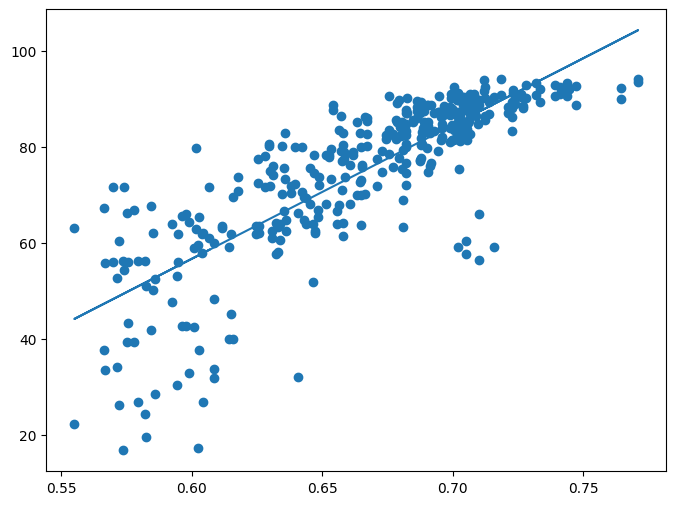

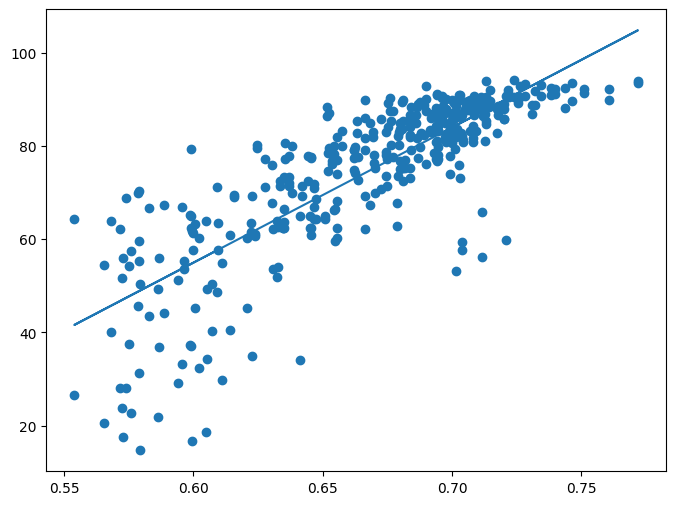

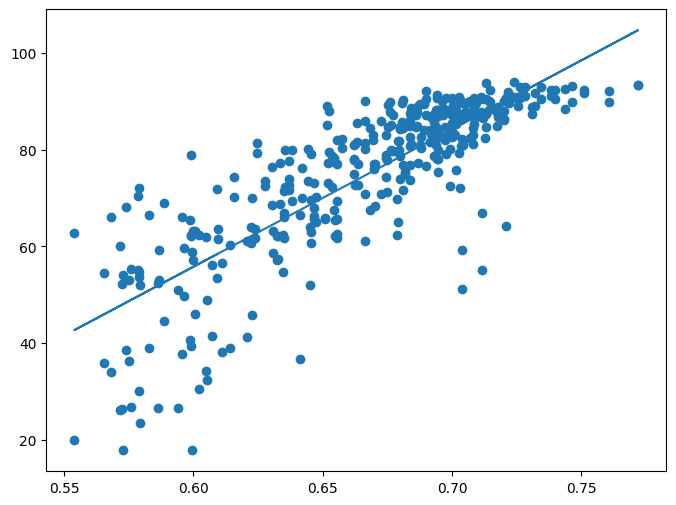

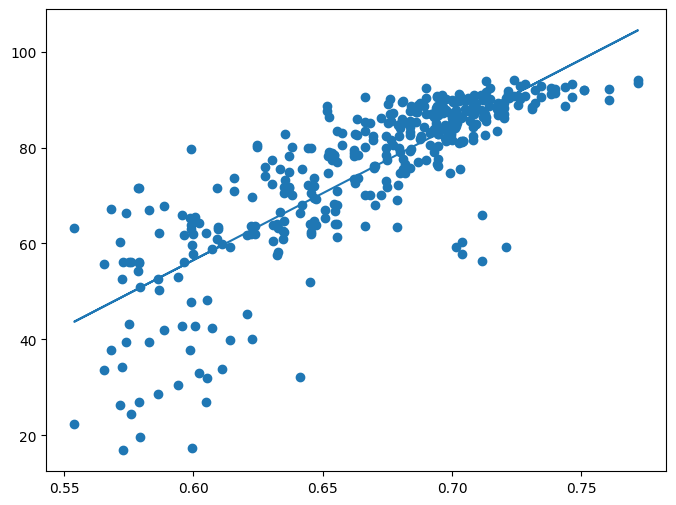

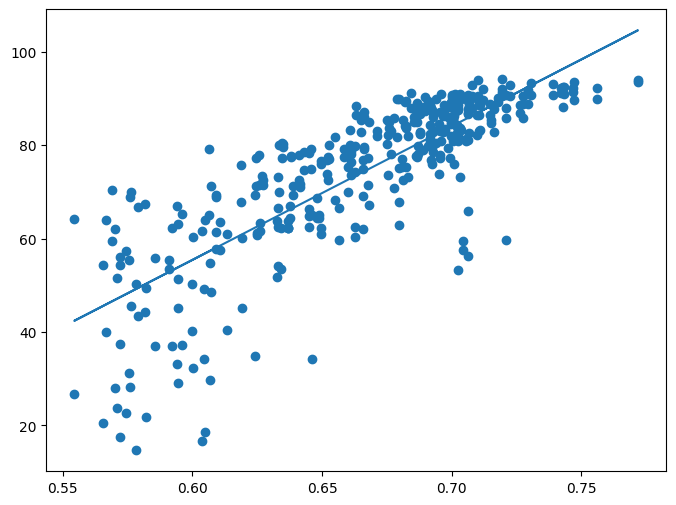

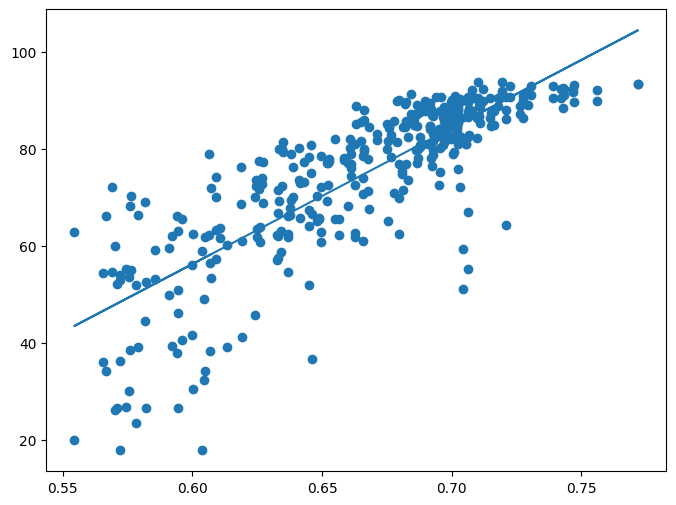

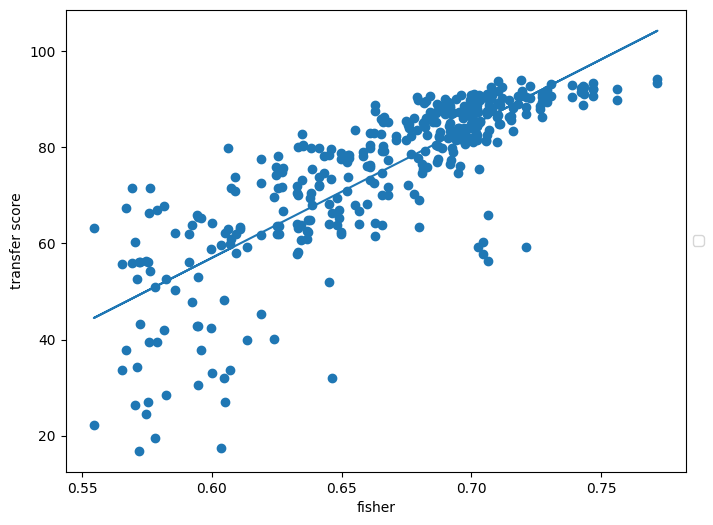

In [3]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score ,mean_squared_error

seeds = [42,10,16]
model_name = 'xlm-roberta-base'
task = 'pos'

feature_name = 'fisher'

if task == 'ner':
    dataset = 'wikiann'
elif task == 'pos':
    dataset = 'ud'
elif task == 'tydiqa':
    dataset = 'tydiqa'
elif task =='cls':
    dataset = 'paws-x'
elif task =='nli':
    dataset = 'xnli'

fseeds=[42,10,16]
fshot='full'
if feature_name == 'fisher':
    shot = 1024
else:
    shot =None
percent = 0.15
is_plt =True
free_file = None
if True:
    aver = 0
    
    ndcg = 0
    rmse = 0
for fseed in fseeds:
    for seed in seeds:
        afeature = []
        apre = []
        ascore = []
        scfile = f'./output/output_csv/{seed}/{task}_zeroshot({model_name}).csv'
        score_df = pd.read_csv(scfile)
        score_df.index=list(score_df['Unnamed: 0'])
        score_df.drop(columns=['Unnamed: 0'],inplace=True)
        if free_file != None:
            feature_file = free_file
        elif feature_name == 'regression':
            if task =='tydiqa':
                feature_file = f'./output/output_csv/regression_qa_ols_{seed}.csv'
            else:
                feature_file = f'./output/output_csv/regression_{task}_ols_{seed}.csv'
        elif feature_name =='emb':
            feature_file = f'./output/output_csv/embed_sim_results_csv_per_seed/{task}-{seed}/layer2_embed_sim_result.csv'
        elif shot == None:
            feature_file = f'./output/output_csv/{model_name}/{task}_{dataset}_{feature_name}_{fshot}_{fseed}.csv'
        elif percent ==None:
            feature_file = f'./output/output_csv/{model_name}/{task}_{feature_name}_1024_42_overlap.csv'
        else:
            feature_file = f'./output/output_csv/{model_name}/{feature_name}/{task}_{feature_name}_{dataset}_{shot}_{percent}_{fseed}_overlap.csv'
        feature_df = pd.read_csv(feature_file)
        feature_df.index = list(feature_df['Unnamed: 0'])
        feature_df.drop(columns=['Unnamed: 0'],inplace=True)
        # #language drop

        if task =='tydiqa':        
            dellist = ['korean']
            if len(dellist) != 0 :
                feature_df.drop(columns=dellist,inplace=True)
                feature_df.drop(index=dellist,inplace=True)
                score_df.drop(columns=dellist,inplace=True)
                score_df.drop(index=dellist,inplace=True)

    
        plt.figure(figsize=(8,6))
        for target in score_df.columns:
            if task != 'tydiqa':
                score = list(score_df[target]*100)
            else:
                score = list(score_df[target])
            if target in list(score_df.index):
                cur = score.pop(list(score_df.index).index(target))

            feature = list(feature_df[target])
            feature.pop(list(score_df.index).index(target))
            ascore += score
            afeature += feature

        
        if is_plt:
            a, b = np.polyfit(afeature, ascore, 1)
            plt.scatter(afeature, ascore)
            plt.plot(afeature, a*np.array(afeature)+b)
            apre = list(a*np.array(afeature)+b)
        rmse += (mean_squared_error(ascore,apre)**0.5)
        r,p = stats.pearsonr(ascore,afeature)
       # print(r)
        aver += r
aver /= (len(seeds)*len(fseeds))
rmse /= (len(seeds)*len(fseeds))
print(f'rmse: {round(rmse,4) }')
print(f'R-square: {round(aver**2,4) }')

# print(f'all spearman: {round(asr,4) } p-value: {round(asp,4)}')
if is_plt:
    plt.xlabel(f'{feature_name}')
    plt.ylabel('transfer score')
    plt.legend(loc='center left', ncol=1, bbox_to_anchor=(1, 0.5))
    plt.show()

# regression

In [ ]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

method =[]
seed =42
model_name = 'xlm-roberta-base'
task = 'tydiqa'

feature_name = 'fisher'
dataset = 'tydiqa'

shot = 1024
p = 0.15
is_plt =True
free_file = None

scfile = f'/home/tjay/Parameter-efficient/TJ/ProjectCode/output/output_csv/{seed}/{task}_zeroshot({model_name}).csv'

score_df = pd.read_csv(scfile,index_col=0) 
feature =[]
feature.append(pd.read_csv(f'./output/output_csv/{model_name}/{task}_{dataset}_lex_sim.csv',index_col=0))
feature.append(pd.read_csv(f'./output/output_csv/{model_name}/{task}_{dataset}_embedding_sim.csv',index_col=0))
feature.append(pd.read_csv(f'./output/output_csv/{model_name}/{task}_{dataset}_ttr_distance.csv',index_col=0))
feature.append(pd.read_csv(f'./output/output_csv/{model_name}/{task}_{dataset}_wf.csv',index_col=0))
feature.append(pd.read_csv(f'./output/output_csv/{model_name}/fisher/{task}_fisher_{dataset}_{shot}_{p}_42_overlap.csv',index_col=0))

coef_df = pd.DataFrame(index=['intercept','ldnd','e_s','ttr','wf','fisher'],columns=score_df.columns)
# language drop
for feature_df in feature: 
    feature_df.drop(columns=['korean'],inplace=True)
    feature_df.drop(index=['korean'],inplace=True)
score_df.drop(columns=['korean'],inplace=True)
score_df.drop(index=['korean'],inplace=True)



total_r2 = 0
total_rmse = 0
total_r2_without = 0
total_rmse_without = 0
top1 = 0
without_top1 = 0
for target in score_df.columns:
    df = pd.DataFrame(index=score_df.columns)
    df['lex'] = feature[0][target]
    df['e_s'] = feature[0][target]
    df['ttr'] = feature[1][target]
    df['wf'] = feature[2][target]
    df['fisher'] = feature[3][target]
    if task not in ['tydiqa','mlqa']:
        df['score'] = score_df[target]*100
    else:
        df['score'] = score_df[target]
    df = df.drop(target)

    #coef_df.loc['intercept',target] = reg.intercept_
    # coef_df.loc['ldnd',target] = reg.coef_[0]
    # coef_df.loc['e_s',target] = reg.coef_[1]
    # coef_df.loc['ttr',target] = reg.coef_[2]
    # coef_df.loc['wf',target] = reg.coef_[3]
    # coef_df.loc['fisher',target] = reg.coef_[4]
    

    reg = LinearRegression().fit(df[['lex','e_s','ttr','wf','fisher']],df['score'])
    reg_without = LinearRegression().fit(df[['lex','e_s','ttr','wf']],df['score'])

    RMSEwith = mean_squared_error(df['score'],reg.coef_[0]*df['lex']+reg.coef_[1]*df['e_s']+reg.coef_[2]*df['ttr']+reg.coef_[3]*df['wf']+reg.coef_[4]*df['fisher'] +reg.intercept_)**0.5
    RMSEwithout = mean_squared_error(df['score'],reg_without.coef_[0]*df['lex']+reg_without.coef_[1]*df['e_s']+reg_without.coef_[2]*df['ttr']+reg_without.coef_[3]*df['wf'] +reg_without.intercept_)**0.5

    total_rmse += RMSEwith
    total_rmse_without += RMSEwithout

    r2 = reg.score(df[['lex','e_s','ttr','wf','fisher']],df['score'])
    r2_without = reg_without.score(df[['lex','e_s','ttr','wf']],df['score'])

    total_r2 += r2
    total_r2_without += r2_without

    # predict
    score = list(df['score'])
    # predict with fisher
    predicted_score = [] 
    for i in range(len(score_df.columns)-1):
        temp = df.iloc[i][['lex','e_s','ttr','wf','fisher']]
        pre = reg.predict([temp])
        predicted_score.append(pre[0])  
    if predicted_score.index(max(predicted_score)) == score.index(max(score)):
        top1 += 1
    # predict with out fisher
    predicted_score = []
    for i in range(len(score_df.columns)-1):
        temp = df.iloc[i][['lex','e_s','ttr','wf']]
        pre = reg_without.predict([temp])
        predicted_score.append(pre[0])
    # print(RMSEwithout)
    # print(predicted_score)
    # print(score)
    if predicted_score.index(max(predicted_score)) == score.index(max(score)):
        without_top1 += 1
print(f'top1 {round(top1/len(score_df.columns),4)}')
print(f'avarage R square {round(total_r2/len(score_df.columns),4)}')
print(f'avarage RMSE {round(total_rmse/len(score_df.columns),4)}')
print(f'without fisher top1 {round(without_top1/len(score_df.columns),4)}')
print(f'avarage R square without fisher {total_r2_without/len(score_df.columns)}')
print(f'avarage RMSE without fisher {total_rmse_without/len(score_df.columns)}')
#coef_df.to_csv(f'/home/tjay/Parameter-efficient/TJ/ProjectCode/output/output_csv/regression/{task}_regression.csv')

# mask analysis (percent)

In [ ]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

p = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
shot = 1024

mask = 'fisher'
task = 'pos'
model_name = 'xlm-roberta-base'
seeds = [42]
dataset = 'ud'


pearson = []
spearman = []
top1 = []
top3 = []

for percent in p:
    aver = 0
    saver = 0
    acc = 0
    top3acc = 0
    for seed in seeds:
        scfile = f'/home/tjay/Parameter-efficient/TJ/ProjectCode/output/output_csv/{seed}/{task}_zeroshot({model_name}).csv'
        score_df = pd.read_csv(scfile)
        score_df.index=list(score_df['Unnamed: 0'])
        score_df.drop(columns=['Unnamed: 0'],inplace=True)

        if mask != 'sign':
            feature_file = f'/home/tjay/Parameter-efficient/TJ/ProjectCode/output/output_csv/{model_name}/{mask}/{task}_{mask}_{dataset}_{int(shot)}_{percent}_{seed}_overlap.csv'
            #feature_file = '/home/tjay/Parameter-efficient/TJ/ProjectCode/output/output_csv/xlm-roberta-base/fisher/pos_fisher_ud_1024_0.3_42_overlap.csv'
        else:
            feature_file = f'/home/tjay/Parameter-efficient/TJ/ProjectCode/output/output_csv/{model_name}/{task}_{mask}_{int(shot)}_{seed}_overlap.csv'
            #feature_file = '/home/tjay/Parameter-efficient/TJ/ProjectCode/output/output_csv/xlm-roberta-base/[POS_MASK]overlapping(shot1024_seed504_pdot4_POS).csv'
        feature_df = pd.read_csv(feature_file)
        feature_df.index = list(feature_df['Unnamed: 0'])
        feature_df.drop(columns=['Unnamed: 0'],inplace=True)

        
        
        for target in score_df.columns:
            score = list(score_df[target])
            if target in list(score_df.index):
                cur = score.pop(list(score_df.index).index(target))

            feature = list(feature_df[target])
            feature.pop(list(score_df.index).index(target))

            r,pvalue = stats.pearsonr(score,feature)
            sr,spvalue = stats.spearmanr(score,feature)

            #print(f'{target} -> pearson :{round(r,4)}  p-value :{round(p,4)}')
            aver += r
            saver += sr

            if feature.index(max(feature)) == score.index(max(score)):
                acc +=1
            sorted_mask = sorted(feature,reverse=True)
            
            for i in range(3):
                if score[feature.index(sorted_mask[i])] == max(score):
                    top3acc += 1
                    break 
    pearson.append(aver/len(score_df.index)/len(seeds))
    spearman.append(saver/len(score_df.index)/len(seeds))
    top1.append(acc/(len(score_df.index)-1)/len(seeds))
    top3.append(top3acc/(len(score_df.index)-1)/len(seeds))

plt.figure(figsize=(8,6))
plt.plot(p,pearson,label='pearson')
plt.plot(p,spearman,label='spearman')
plt.plot(p,top1,label='top1')
plt.plot(p,top3,label='top3')

plt.xlabel('percent')
plt.ylabel('correlation')
plt.title(f'{task} correlation with {mask} mask')
plt.legend(loc='center left', ncol=1, bbox_to_anchor=(0.8, 0.9))
plt.show()


# box plot

In [ ]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

ner = pd.read_csv('./output/output_csv/output/output_csv/42/ner_zeroshot(xlm-roberta-base).csv') 
pos = pd.read_csv('./output/output_csv/output_csv/42/pos_zeroshot(xlm-roberta-base).csv')
tydi = pd.read_csv('./output/output_csv/xlm-roberta-base/tydiqa_modelseed42_2K_zeroshot_em.csv')
mlqa = pd.read_csv('./output/output_csv/xlm-roberta-base/mlqa_modelseed42_zeroshot_em.csv')
nli = pd.read_csv('./output/output_csv/xlm-roberta-base/NLI(Zeroshot).csv')
cls = pd.read_csv('./output/output_csv/xlm-roberta-base/CLS(Zeroshot).csv')
def to_list(df):
    lis=[]
    for target in df.columns:
        score = list(df[target])
        cur = score.pop(list(df.index).index(target))
        nscore = list((np.array(score)-np.array(score).mean())*100)
        lis += nscore
    return lis
score_lis = [ner,pos,tydi,mlqa,nli,cls]
for score_df in score_lis:
    score_df.index=list(score_df['Unnamed: 0'])
    score_df.drop(columns=['Unnamed: 0'],inplace=True)
ner_nscore=to_list(ner)
pos_nscore=to_list(pos)
tydi_nscore=to_list(tydi)
mlqa_nscore=to_list(mlqa)
nli_nscore=to_list(nli)
cls_nscore=to_list(cls)

plt.figure(figsize=(8,6))
plt.boxplot([ner_nscore,pos_nscore,tydi_nscore,mlqa_nscore,nli_nscore,cls_nscore],notch=True, whis=2.5)
plt.xticks([1,2,3,4,5,6],['NER','POS','TyDiQA','MLQA','NLI','PAWS-X'])
plt.show()